In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys    
path_to_module = '/content/gdrive/MyDrive/LMPC_for_autonomous_racing'
sys.path.append(path_to_module)


In [ ]:
cd 

/root


In [ ]:
import matplotlib.pyplot as plt
from fnc.plot import plotTrajectory, plotClosedLoopLMPC, plot_predicted_trajectory, animation_states, saveGif_xyResults

In [ ]:
# import sys
# sys.path.append('fnc')
import matplotlib.pyplot as plt
from fnc.plot import plotTrajectory, plotClosedLoopLMPC, plot_predicted_trajectory, animation_states, saveGif_xyResults
from initControllerParameters import initMPCParams, initLMPCParams
from fnc.PredictiveControllers import MPC, LMPC, MPCParams
from fnc.PredictiveModel import PredictiveModel
from fnc.Utilities import Regression, PID
from fnc.Track import Map
import numpy as np
import pickle
import pdb
import sys,os



In [ ]:
import numpy as np

class SIMULATOR(object):
	""" Finite Time Optimal Control Problem (FTOCP)
	Methods:
		- solve: solves the FTOCP given the initial condition x0, terminal contraints (optinal) and terminal cost (optional)
		- model: given x_t and u_t computes x_{t+1} = Ax_t + Bu_t
	"""
	def __init__(self, system, A = [], B = [], radius = [], dt = 0.1,  map = []):
		# Define variables
		self.system = system
		self.A = A
		self.B = B
		self.radius = radius
		self.dt = dt
		self.map = map

	def sim(self, x, u):
		if self.system == "linear_system":
			x_next = self.linear_system(x,u)
		elif self.system == "unicycle":
			x_next = self.unicycle(x,u)
		elif self.system == "dyn_bicycle_model":
			x, x_glob = self.dyn_bicycle_model(x, u)
			x_next = [x, x_glob]
		return x_next

	def linear_system(self, x,u):
		return (np.dot(self.A,x) + np.squeeze(np.dot(self.B,u))).tolist()

	def unicycle(self, x, u):
		# Given a state x and input u it return the successor state
		xNext = np.array([x[0] + self.dt * x[2]*np.cos(u[0] - x[0]/self.radius) / (1 - x[1] / self.radius),
						  x[1] + self.dt * x[2]*np.sin(u[0] - x[0]/self.radius),
						  x[2] + self.dt * u[1]])
		return xNext.tolist()


	# Introduce function for computing road edges
	def computeRoadEdges(self, s_start, s_end, circleRadius, roadHalfWidth, signEdge = 1, disc = 1):
		edges = []
		for k in np.arange(s_start, s_end+disc, disc):#in range(s_start*disc, s_end*disc):
			angle  = k/circleRadius
			radius = circleRadius  + signEdge * roadHalfWidth
			edges.append([radius*np.sin(angle), circleRadius-radius*np.cos(angle)])

		return np.array(edges)

	# Introduce function for change of coordinates from curvilinear absicssa to XY
	def from_curvilinear_to_xy(self, xcl_feasible):
		feasibleTraj = []
		for k in range(0, np.shape(np.array(xcl_feasible))[0]):
			angle  = np.array(xcl_feasible)[k, 0]/self.radius
			radius_curr = self.radius  - np.array(xcl_feasible)[k, 1]
			feasibleTraj.append([radius_curr*np.sin(angle), self.radius-radius_curr*np.cos(angle)])

		return feasibleTraj


	def dyn_bicycle_model(self, x_states_list, u):
		# This method computes the system evolution. Note that the discretization is deltaT and therefore is needed that
		# dt <= deltaT and ( dt / deltaT) = integer value
		x = np.array(x_states_list[0])
		x_glob = np.array(x_states_list[1])

		# Vehicle Parameters
		m  = 1.98
		lf = 0.125
		lr = 0.125
		Iz = 0.024
		Df = 0.8 * m * 9.81 / 2.0
		Cf = 1.25
		Bf = 1.0
		Dr = 0.8 * m * 9.81 / 2.0
		Cr = 1.25
		Br = 1.0

		# Discretization Parameters
		deltaT = 0.001
		x_next	 = np.zeros(x.shape[0])
		cur_x_next = np.zeros(x.shape[0])

		# Extract the value of the states
		delta = u[0]
		a	 = u[1]

		psi = x_glob[3]
		X = x_glob[4]
		Y = x_glob[5]

		vx	= x[0]
		vy	= x[1]
		wz	= x[2]
		epsi  = x[3]
		s	 = x[4]
		ey	= x[5]

		# Initialize counter
		i = 0
		while( (i+1) * deltaT <= self.dt):
			# Compute tire split angle
			alpha_f = delta - np.arctan2( vy + lf * wz, vx )
			alpha_r = - np.arctan2( vy - lf * wz , vx)

			# Compute lateral force at front and rear tire
			Fyf = Df * np.sin( Cf * np.arctan(Bf * alpha_f ) )
			Fyr = Dr * np.sin( Cr * np.arctan(Br * alpha_r ) )

			# Propagate the dynamics of deltaT
			x_next[0] = vx  + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy)
			x_next[1] = vy  + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			x_next[2] = wz  + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) )
			x_next[3] = psi + deltaT * (wz)
			x_next[4] =   X + deltaT * ((vx * np.cos(psi) - vy * np.sin(psi)))
			x_next[5] =   Y + deltaT * (vx * np.sin(psi)  + vy * np.cos(psi))

			cur = self.map.curvature(s)
			cur_x_next[0] = vx   + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy)
			cur_x_next[1] = vy   + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			cur_x_next[2] = wz   + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) )
			cur_x_next[3] = epsi + deltaT * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
			cur_x_next[4] = s	+ deltaT * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
			cur_x_next[5] = ey   + deltaT * (vx * np.sin(epsi) + vy * np.cos(epsi))

			# Update the value of the states
			psi  = x_next[3]
			X	= x_next[4]
			Y	= x_next[5]

			vx   = cur_x_next[0]
			vy   = cur_x_next[1]
			wz   = cur_x_next[2]
			epsi = cur_x_next[3]
			s	= cur_x_next[4]
			ey   = cur_x_next[5]

			# Increment counter
			i = i+1

		# Noises
		noise_vx = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_vy = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_wz = np.max([-0.05, np.min([np.random.randn() * 0.005, 0.05])])

		cur_x_next[0] = cur_x_next[0] + 0.01*noise_vx
		cur_x_next[1] = cur_x_next[1] + 0.01*noise_vy
		cur_x_next[2] = cur_x_next[2] + 0.01*noise_wz

		x_next[0] = x_next[0] + 0.01*noise_vx
		x_next[1] = x_next[1] + 0.01*noise_vy
		x_next[2] = x_next[2] + 0.01*noise_wz

		return cur_x_next.tolist(), x_next.tolist()

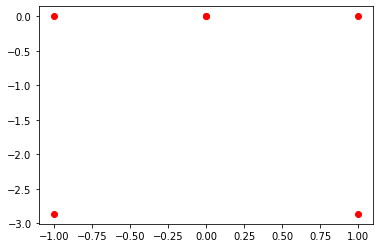

In [ ]:
# ======================================================================================================================
# ============================================= Initialize parameters  =================================================
# ======================================================================================================================
N = 14                                    # Horizon length
n = 6;   d = 2                            # State and Input dimension
x0 = [0.5, 0, 0, 0, 0, 0]                 # Initial condition

dt = 0.1

map = Map(0.4)                            # Initialize map
vt = 0.8                                  # target vevlocity

# Initialize controller parameters
mpcParam, ltvmpcParam = initMPCParams(n, d, N, vt)
numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters = initLMPCParams(map, N)

# Init simulators
simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=0.1)


In [ ]:
# ======================================================================================================================
# ======================================= PID path following ===========================================================
# ======================================================================================================================
print("Starting PID")
# Initialize pid and run sim
PIDController = PID(vt)
t_max = 1000

xcl_pid = [x0]
xcl_pid_glob = [x0]
ucl_pid = []

for time in range(t_max):
    # read measurement
    xt = xcl_pid[time] 

    # Solve LMPC
    PIDController.solve(xt) 

    # Apply input and store closed-loop data
    ut = PIDController.uPred[:,0]
    ucl_pid.append(ut.tolist())
    x_next = simulator.sim([xcl_pid[time], xcl_pid_glob[time]], ut) # Simulate both in global and local coordinates
    xcl_pid.append(x_next[0])
    xcl_pid_glob.append(x_next[1])

    # increment time counter
    time += 1


Starting PID


In [ ]:
# ======================================================================================================================
# ==============================  LMPC w\ LOCAL LINEAR REGRESSION ======================================================
# ======================================================================================================================
print("Starting LMPC")
# Initialize Predictive Model for lmpc
predictiveModel = PredictiveModel(n, d, map, 4)
for i in range(0,4): # add trajectories used for model learning
    predictiveModel.addTrajectory(np.array(xcl_pid)[:-1,:], np.array(ucl_pid))

# Initialize Controller
lmpcParameters.timeVarying     = True 
lmpc = LMPC(numSS_Points, numSS_it, QterminalSlack, lmpcParameters, predictiveModel)
for i in range(0,numSS_it): # add trajectories for safe set
    lmpc.addTrajectory( np.array(xcl_pid)[:-1,:], np.array(ucl_pid), np.array(xcl_pid_glob)[:-1,:])

# Run sevaral laps
for it in range(numSS_it, Laps):
    time = 0
    if it == numSS_it:
        xcl = [x0]
        xcl_glob = [x0]
    else:
        x_final = xcl[-1]
        x_start = x_final[:]
        x_start[4] = x_start[4] - map.TrackLength
        xcl = [x_start]
        xcl_glob = [xcl_glob[-1]]
    ucl = []
    while (xcl[-1][4] <= map.TrackLength): # Simulate one lap
            # Read measurement
            xt = xcl[time] 
            
            # Solve LMPC
            lmpc.solve(xcl[-1])
            ut = lmpc.uPred[0,:]
                        
            # Run simulation
            xt, xt_glob = simulator.sim([xcl[-1], xcl_glob[-1]], ut)

            # Add points
            ucl.append(ut)
            lmpc.addPoint(np.array(xcl[-1]), np.array(ucl[-1])) # This is needed to extend the safe set beyond the finish line
            xcl.append(xt)
            xcl_glob.append(xt_glob)
                
            # Update time
            time += 1
    
    # Add trajectory to controller
    lmpc.addTrajectory( np.array(xcl)[:-1,:], np.array(ucl), np.array(xcl_glob)[:-1,:])
    predictiveModel.addTrajectory(np.array(xcl)[:-1,:], np.array(ucl))              
    print("Completed lap: ", it, " in ", np.round(lmpc.Qfun[it][0]*dt, 2)," seconds")

print("===== LMPC terminated")
    

Starting LMPC
Completed lap:  4  in  13.7  seconds
Completed lap:  5  in  11.3  seconds
Completed lap:  6  in  10.0  seconds
Completed lap:  7  in  9.1  seconds
Completed lap:  8  in  8.4  seconds
Completed lap:  9  in  7.8  seconds
Completed lap:  10  in  7.2  seconds
Completed lap:  11  in  6.6  seconds
Completed lap:  12  in  6.1  seconds
Completed lap:  13  in  5.7  seconds
Completed lap:  14  in  5.7  seconds
Completed lap:  15  in  5.4  seconds
Completed lap:  16  in  5.5  seconds
Completed lap:  17  in  5.3  seconds
Completed lap:  18  in  5.3  seconds
Completed lap:  19  in  5.1  seconds
Completed lap:  20  in  5.1  seconds
Completed lap:  21  in  5.1  seconds
Completed lap:  22  in  5.1  seconds
Completed lap:  23  in  5.1  seconds
Completed lap:  24  in  5.1  seconds
Completed lap:  25  in  5.1  seconds
Completed lap:  26  in  5.1  seconds
Completed lap:  27  in  4.9  seconds
Completed lap:  28  in  4.9  seconds
Completed lap:  29  in  4.9  seconds
Completed lap:  30  in  4.9

## Plot closed-loop trajectories

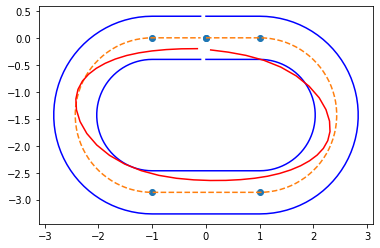

In [ ]:
# Plot the last last_laps_to_plot
plotClosedLoopLMPC(lmpc, map, last_laps_to_plot=1)

In [ ]:
x= lmpc.SS_glob[43][0:lmpc.LapTime[43],4]
#np.shape(x)
#x

array([ 0.08765356,  0.41116907,  0.74401491,  1.07547839,  1.39199491,
        1.67792624,  1.91950093,  2.10648348,  2.23311975,  2.29875805,
        2.30732339,  2.26603159,  2.18367061,  2.06857782,  1.92684216,
        1.76210487,  1.57636804,  1.37091686,  1.14684162,  0.90510789,
        0.64630591,  0.37072704,  0.07906033, -0.22804432, -0.54862194,
       -0.8770665 , -1.20320342, -1.5136901 , -1.79415625, -2.03167419,
       -2.21652867, -2.34294556, -2.40983991, -2.42037553, -2.38093909,
       -2.29971369, -2.18457333, -2.041549  , -1.87450845, -1.6857651 ,
       -1.47689219, -1.24913023, -1.00331075, -0.73970749, -0.45858491,
       -0.16046334])

In [ ]:
y= lmpc.SS_glob[43][0:lmpc.LapTime[43],5]
#np.shape(y)
#y

array([-0.22464513, -0.26520422, -0.3257061 , -0.41625698, -0.54262173,
       -0.70528296, -0.89865966, -1.11213373, -1.33194731, -1.54415281,
       -1.73755842, -1.90622159, -2.05026086, -2.17351291, -2.27976047,
       -2.37111944, -2.44919565, -2.51427292, -2.56589226, -2.60359906,
       -2.62900115, -2.64327945, -2.6451151 , -2.63330244, -2.60408893,
       -2.55005535, -2.46348616, -2.33975339, -2.17922312, -1.98746434,
       -1.77430894, -1.55253792, -1.33522669, -1.13390254, -0.95622968,
       -0.80412286, -0.67529065, -0.56578187, -0.47219546, -0.39289239,
       -0.32809327, -0.27874059, -0.24291576, -0.21810639, -0.20392149,
       -0.20096914])

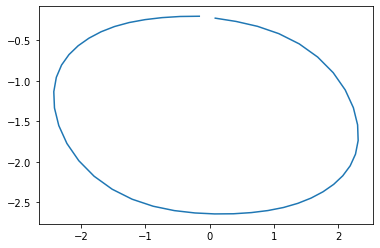

In [ ]:
plt.plot(x,y)

In [ ]:
Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
Points1 = np.zeros((Points, 2))
Points2 = np.zeros((Points, 2))
Points0 = np.zeros((Points, 2))

In [ ]:
 for i in range(0, int(Points)):
            Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
            Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
            Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)

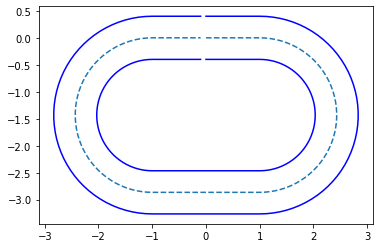

In [ ]:
plt.plot(Points0[:, 0], Points0[:, 1], '--')
plt.plot(Points1[:, 0], Points1[:, 1], '-b')
plt.plot(Points2[:, 0], Points2[:, 1], '-b')

In [ ]:
np.shape(Points1)

(130, 2)

In [ ]:
np.save("centerline.npy",Points0)
np.save("TracklineUp.npy",Points1)
np.save("TracklineLow.npy",Points2)


In [ ]:
pp =np.load("centerline.npy")

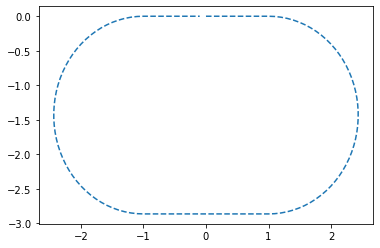

In [ ]:
plt.plot(pp[:, 0], pp[:, 1], '--')

In [29]:
traj = np.array([x])

In [30]:
traj

array([[ 0.08765356,  0.41116907,  0.74401491,  1.07547839,  1.39199491,
         1.67792624,  1.91950093,  2.10648348,  2.23311975,  2.29875805,
         2.30732339,  2.26603159,  2.18367061,  2.06857782,  1.92684216,
         1.76210487,  1.57636804,  1.37091686,  1.14684162,  0.90510789,
         0.64630591,  0.37072704,  0.07906033, -0.22804432, -0.54862194,
        -0.8770665 , -1.20320342, -1.5136901 , -1.79415625, -2.03167419,
        -2.21652867, -2.34294556, -2.40983991, -2.42037553, -2.38093909,
        -2.29971369, -2.18457333, -2.041549  , -1.87450845, -1.6857651 ,
        -1.47689219, -1.24913023, -1.00331075, -0.73970749, -0.45858491,
        -0.16046334]])

In [34]:
traj = np.atleast_2d(x,y)
np.save("traj.npy",traj)

In [ ]:
from google.colab import files
files.download("traj.npy")
files.download("centerline.npy")
files.download("TracklineUp.npy")
files.download("TracklineLow.npy")